In [1]:
%load_ext rpy2.ipython
import rpy2.robjects.lib.ggplot2 as ggplot2
import childespy
import numpy as np
import os
import imp
import pandas as pd
import transformers
import torch
import re
import unicodedata
import scipy.stats
import copy
from string import punctuation

import copy

In [2]:
from utils_model_sampling import sample_models_across_time
from utils import load_models

In [3]:
# 7/2/21: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2
# end cite

## Note: running on unigram scores that may not be fully correct -- will correct when OM is back up.

In [4]:

raw_scores_across_time = pd.concat(sample_models_across_time.assemble_scores_no_order())

/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/all/all/Adult_BERT_without_tags,_,_same_utt_only/run_models_across_time_1.0.pkl
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/all/all/Adult_BERT_without_tags,_,_same_utt_only/run_models_across_time_4.0.pkl
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/all/all/Adult_BERT_without_tags,_,_same_utt_only/run_models_across_time_2.0.pkl
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/all/all/Adult_BERT_without_tags,_,_same_utt_only/run_models_across_time_0.5.pkl
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/all/all/Adult_BERT_without_tags,_,_same_utt_only/r

/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/age/old/CHILDES_BERT_with_tags,_older_children,_+-20_utts_context/run_models_across_time_4.0.pkl
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/age/old/CHILDES_BERT_with_tags,_older_children,_+-20_utts_context/run_models_across_time_2.0.pkl
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/age/old/CHILDES_BERT_with_tags,_older_children,_+-20_utts_context/run_models_across_time_0.5.pkl
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/age/old/CHILDES_BERT_with_tags,_older_children,_+-20_utts_context/run_models_across_time_2.5.pkl
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning

In [5]:
# Possibly too complex to generate the betas in the title automatically
# -- for now, just display the betas in the notebook separately.

from utils_model_sampling import beta_utils
from pprint import pprint

all_args = load_models.gen_all_model_args()

beta_set = {}
for arg_set in all_args:
    model_title = load_models.gen_model_title(*arg_set)
    this_beta = beta_utils.get_optimal_beta_value(*arg_set)
    
    beta_set[model_title] = round(this_beta, 3)
    
pprint(beta_set)

{'Adult BERT without tags, , +-20 utts context': 3.3,
 'Adult BERT without tags, , same utt only': 3.4,
 'CHILDES BERT with tags, , +-20 utts context': 3.0,
 'CHILDES BERT with tags, , same utt only': 3.1,
 'CHILDES BERT with tags, older children, +-20 utts context': 3.4,
 'CHILDES BERT with tags, older children, same utt only': 3.4,
 'CHILDES BERT with tags, younger children, +-20 utts context': 3.0,
 'CHILDES BERT with tags, younger children, same utt only': 3.1,
 'CHILDES BERT without tags, , +-20 utts context': 3.0,
 'CHILDES BERT without tags, , same utt only': 3.2,
 'CHILDES BERT without tags, older children, +-20 utts context': 3.4,
 'CHILDES BERT without tags, older children, same utt only': 3.4,
 'CHILDES BERT without tags, younger children, +-20 utts context': 3.1,
 'CHILDES BERT without tags, younger children, same utt only': 3.1,
 'CHILDES unigram without tags, , same utt only': 2.5,
 'Flat prior without tags, , same utt only': 2.5}


In [6]:
# From the original analysis

original_set_of_models = {
    'CHILDES BERT without tags, , +-20 utts context',
    'CHILDES BERT without tags, , same utt only',
    'Adult BERT without tags, , +-20 utts context',
    'Adult BERT without tags, , same utt only',
    'CHILDES Unigram',
    'Flat Unigram', 
}


tags_context_only = {
    "CHILDES BERT with tags, , +-20 utts context",
    'CHILDES BERT with tags, older children, +-20 utts context',
    'CHILDES BERT with tags, younger children, +-20 utts context',
    'CHILDES BERT without tags, , +-20 utts context',
    'CHILDES BERT without tags, older children, +-20 utts context',
    'CHILDES BERT without tags, younger children, +-20 utts context',
    'Flat Unigram',
}

merge_orig_tags = copy.deepcopy(tags_context_only)
merge_orig_tags.update(original_set_of_models)

scores_across_time = raw_scores_across_time.copy()
#scores_across_time = raw_scores_across_time[raw_scores_across_time.model.isin(merge_orig_tags)].copy()


In [7]:
scores_across_time['token'] = scores_across_time['token'].astype(str)
scores_across_time_short = scores_across_time[['posterior_surprisal','posterior_entropy','prior_surprisal',
    'kl_flat_to_prior', 'kl_flat_to_posterior', 'model','set','age','token','bert_token_id', 'edit_distance']]
%R -i scores_across_time_short

In [8]:
%%R
library('plyr')
# rename the models

# Do this manually for now.

model_levels = c("CHILDES BERT with tags, , +-20 utts context",
                 'CHILDES BERT without tags, , +-20 utts context',
                 "CHILDES BERT with tags, , same utt only",
                 "CHILDES BERT without tags, , same utt only",
                 "Adult BERT without tags, , +-20 utts context",
                 "Adult BERT without tags, , same utt only",
                 "CHILDES BERT with tags, older children, +-20 utts context",
                 "CHILDES BERT without tags, older children, +-20 utts context",
                 "CHILDES BERT without tags, older children, same utt only",
                 "CHILDES BERT with tags, older children, same utt only",
                 "CHILDES BERT with tags, younger children, +-20 utts context",
                 "CHILDES BERT without tags, younger children, +-20 utts context",
                 "CHILDES BERT with tags, younger children, same utt only",
                 "CHILDES BERT without tags, younger children, same utt only",
                 "CHILDES Unigram",
                 "Flat Unigram"
)

model_new_levels = c("CHILDES BERT with tags, , +-20 utts context" = "CDL+Context+Tags",
                    "CHILDES BERT without tags, , +-20 utts context" = "CDL+Context",
                    "CHILDES BERT with tags, , same utt only" = "CDL+OneUtt+Tags",
                    "CHILDES BERT without tags, , same utt only" = "CDL+OneUtt", 
                    "Adult BERT without tags, , +-20 utts context" = "BERT+Context",
                    "Adult BERT without tags, , same utt only" = "BERT+OneUtt",
                    "CHILDES BERT with tags, older children, +-20 utts context" = "CDL+Older+Context+Tags",
                    "CHILDES BERT without tags, older children, +-20 utts context" = "CDL+Older+Context",
                    "CHILDES BERT with tags, older children, same utt only" = "CDL+Older+OneUtt+Tags",
                    "CHILDES BERT without tags, older children, same utt only" = "CDL+Older+OneUtt",
                    "CHILDES BERT with tags, younger children, +-20 utts context" = "CDL+Younger+Context+Tags",
                    "CHILDES BERT without tags, younger children, +-20 utts context" = "CDL+Younger+Context",
                    "CHILDES BERT with tags, younger children, same utt only" = "CDL+Younger+OneUtt+Tags", 
                    "CHILDES BERT without tags, younger children, same utt only" = "CDL+Younger+OneUtt",
                    "CHILDES Unigram" = "CHILDES 1gram",
                    "Flat Unigram" = "UniformPrior"
)


scores_across_time_short$model = factor(scores_across_time_short$model, model_levels)
scores_across_time_short$model = revalue(scores_across_time_short$model, model_new_levels)



In [41]:
%R -o scores_across_time_short

successes_across_time = scores_across_time_short[(scores_across_time_short.set == 'success')]

bad_ages = set()

for age in set(successes_across_time.age):
    this_df = successes_across_time[successes_across_time.age == age]
    
    # Drop based on tokens to eliminate what are presumably filler NaN tokens
    # If there's only one datapoint (single token) for a given age
    # (and therefore a given model/age combination)
    # That will result in NaN for the R stdev functions.
    # Data too sparse, so eliminate that age (should be 0.5 basically)
    
    if len(set(this_df.dropna(subset=['token'])['bert_token_id'])) == 1:
        bad_ages.add(age)
        
successes_across_time = successes_across_time[~successes_across_time.isin(bad_ages)]

%R -i successes_across_time


# 10 Average Prior Surprisal

In [42]:
%%R
names(successes_across_time)

aggregate(prior_surprisal ~ model, successes_across_time, function(x){mean(-1 * log(x, base = 2))})

                      model prior_surprisal
1          CDL+Context+Tags        3.321106
2               CDL+Context        3.423511
3           CDL+OneUtt+Tags        4.990031
4                CDL+OneUtt        5.110099
5              BERT+Context        4.741972
6               BERT+OneUtt        7.285485
7    CDL+Older+Context+Tags        3.388266
8         CDL+Older+Context        3.502932
9          CDL+Older+OneUtt        5.335795
10    CDL+Older+OneUtt+Tags        5.068990
11 CDL+Younger+Context+Tags        3.487286
12      CDL+Younger+Context        3.512313
13  CDL+Younger+OneUtt+Tags        5.184650
14       CDL+Younger+OneUtt        5.233894
15            CHILDES 1gram       18.297190
16             UniformPrior       12.948367


In [43]:
%%R

# 7/15/21 not a code reference, but debugging help:
# https://stackoverflow.com/questions/60083062/tidyrspread-error-each-row-of-output-must-be-identified-by-a-unique-combina
# https://community.rstudio.com/t/spread-error-each-row-of-output-must-be-identified-by-a-unique-combination-of-keys/88325
# https://garrettgman.github.io/tidying

library('tidyr')
successes_across_time_wide =  spread(successes_across_time[,c('model','prior_surprisal',
'bert_token_id')], model, prior_surprisal)

head(successes_across_time_wide)

  bert_token_id CDL+Context+Tags  CDL+Context CDL+OneUtt+Tags   CDL+OneUtt
1         49676     0.0009260167 0.0007204352     0.001790194 0.0019628888
2         52857     0.0110804634 0.0256987140     0.001949325 0.0015860118
3         60498     0.0001718302 0.0025232614     0.001306169 0.0042884611
4         60499     0.0005986911 0.0008698311     0.000208751 0.0001290685
5         65634     0.1349055618 0.1811656952     0.085646421 0.0711195245
6         65852     0.0875518247 0.0445239507     0.085646421 0.0711195245
  BERT+Context  BERT+OneUtt CDL+Older+Context+Tags CDL+Older+Context
1 1.374463e-05 5.328564e-05           0.0004065618      1.806228e-04
2 3.800371e-03 2.886749e-04           0.0046467707      1.144458e-02
3 5.194001e-02 2.543838e-02           0.0134188002      3.004536e-03
4 3.491802e-06 4.082376e-05           0.0002857940      2.468799e-05
5 3.223022e-01 1.886122e-02           0.2467705309      2.004428e-01
6 4.058891e-02 1.886122e-02           0.0570895337      2.411

In [44]:
%%R
#Pairwise paired t-test between all of the models

model_names = unique(successes_across_time$model) 

rvs = mat.or.vec(length(model_names), length(model_names))

for (model_idx in c(1:length(model_names))){
    for (comparison_model_idx in c(1:length(model_names))){
        if (model_idx == comparison_model_idx){
            rvs[model_idx, comparison_model_idx] = NA
        } else {
            model_name = model_names[model_idx]
            comparison_model_name = model_names[comparison_model_idx]
            rvs[model_idx, comparison_model_idx] = t.test(
                successes_across_time_wide[[model_name]], 
                successes_across_time_wide[[comparison_model_name]],
              paired=T)$p.value
        }
    }
}
rvs = data.frame(rvs)

rownames(rvs) = model_names
colnames(rvs) = model_names

rvs

                          BERT+Context   BERT+OneUtt   CDL+Context
BERT+Context                        NA  2.927346e-57  0.000000e+00
BERT+OneUtt               2.927346e-57            NA 2.463774e-236
CDL+Context               0.000000e+00 2.463774e-236            NA
CDL+Context+Tags          0.000000e+00  0.000000e+00  0.000000e+00
CDL+Older+Context         0.000000e+00 6.912283e-255  1.163137e-02
CDL+Older+Context+Tags   1.232566e-150  0.000000e+00  0.000000e+00
CDL+Older+OneUtt          0.000000e+00 3.220407e-270  2.996740e-01
CDL+Older+OneUtt+Tags     3.153082e-06  9.323301e-72  0.000000e+00
CDL+OneUtt                9.890538e-01  1.128356e-56  0.000000e+00
CDL+OneUtt+Tags           0.000000e+00 1.633751e-246  1.657992e-01
CDL+Younger+Context       0.000000e+00 1.505209e-196  2.863954e-08
CDL+Younger+Context+Tags  1.139567e-04  6.606858e-70  0.000000e+00
CDL+Younger+OneUtt        1.961724e-20  2.000660e-81  0.000000e+00
CDL+Younger+OneUtt+Tags   0.000000e+00 8.542298e-236  2.273535

### Posterior Surprisal Across Ages

In [45]:
%R sem <- function(x) sd(x)/sqrt(length(x))
%R mean_surprisal_by_age = aggregate(posterior_surprisal ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x, base = 2))})
%R names(mean_surprisal_by_age) = c('age','model','posterior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(posterior_surprisal ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','posterior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 
%R print(mean_surprisal_by_age)

    age                    model posterior_surprisal_mean
1   1.5             BERT+Context                2.6426948
2   1.5              BERT+OneUtt                4.5156023
3   1.5              CDL+Context                1.7674212
4   1.5         CDL+Context+Tags                1.7191905
5   1.5        CDL+Older+Context                1.8759416
6   1.5   CDL+Older+Context+Tags                1.8512236
7   1.5         CDL+Older+OneUtt                3.1968645
8   1.5    CDL+Older+OneUtt+Tags                3.0821633
9   1.5               CDL+OneUtt                3.0717287
10  1.5          CDL+OneUtt+Tags                3.0277522
11  1.5      CDL+Younger+Context                1.7596790
12  1.5 CDL+Younger+Context+Tags                1.7148751
13  1.5       CDL+Younger+OneUtt                2.9931307
14  1.5  CDL+Younger+OneUtt+Tags                3.0592099
15  1.5            CHILDES 1gram               11.4846924
16  1.5             UniformPrior                6.4159593
17  1.0       

58               0.10488200
59               0.08040165
60               0.08227893
61               0.10339854
62               0.10759054
63               0.19583367
64               0.10052029
65               0.06066149
66               0.07860731
67               0.05274605
68               0.05308646
69               0.05450325
70               0.05587680
71               0.07128898
72               0.07359625
73               0.07180171
74               0.07138588
75               0.05366743
76               0.05480828
77               0.07180518
78               0.07565216
79               0.13287475
80               0.07294037
81               0.08126312
82               0.09922665
83               0.06275328
84               0.06295262
85               0.06519653
86               0.06508038
87               0.07891527
88               0.07897775
89               0.07588139
90               0.07685731
91               0.06311119
92               0.06371598
93               0.0

,age,model,posterior_surprisal_mean,posterior_surprisal_sem
1,1.5,BERT+Context,2.642695,0.153109
2,1.5,BERT+OneUtt,4.515602,0.183540
3,1.5,CDL+Context,1.767421,0.125771
4,1.5,CDL+Context+Tags,1.719191,0.123495
5,1.5,CDL+Older+Context,1.875942,0.134646
...,...,...,...,...
108,4.0,CDL+Younger+Context+Tags,0.972883,0.071221
109,4.0,CDL+Younger+OneUtt,1.272775,0.084394
110,4.0,CDL+Younger+OneUtt+Tags,1.288961,0.086324
111,4.0,CHILDES 1gram,9.550581,0.186640


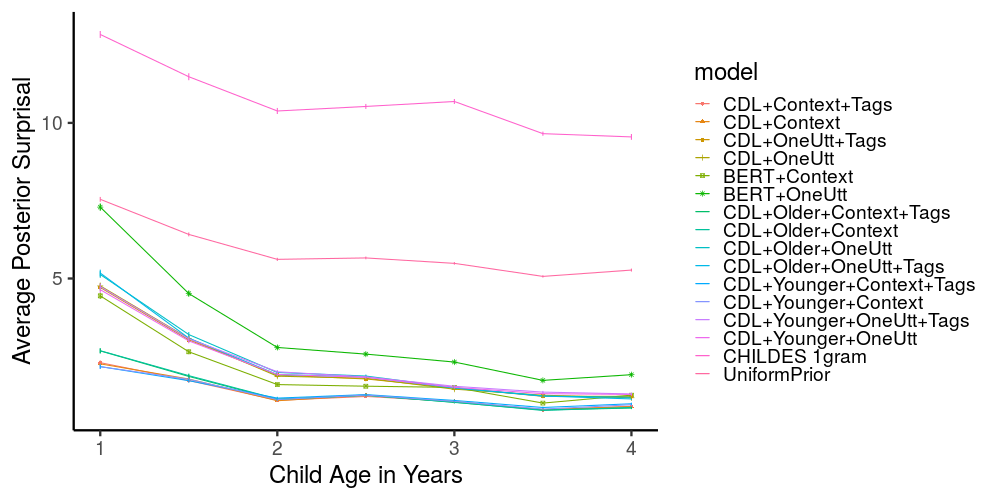

In [46]:
%%R -w 1000 -h 500
ggplot(mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years')

### Prior Surprisal Across Ages

In [47]:
## scores_across_time = pd.concat(score_store)
%R mean_surprisal_by_age = aggregate(prior_surprisal ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age) = c('age','model','prior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(prior_surprisal ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x, base = 2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','prior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 

,age,model,prior_surprisal_mean,prior_surprisal_sem
1,1.5,BERT+Context,5.637503,0.179214
2,1.5,BERT+OneUtt,9.110242,0.188713
3,1.5,CDL+Context,3.846919,0.161299
4,1.5,CDL+Context+Tags,3.626939,0.156541
5,1.5,CDL+Older+Context,4.055461,0.168421
...,...,...,...,...
108,4.0,CDL+Younger+Context+Tags,3.481106,0.134280
109,4.0,CDL+Younger+OneUtt,4.635928,0.146649
110,4.0,CDL+Younger+OneUtt+Tags,4.558487,0.146522
111,4.0,CHILDES 1gram,17.719039,0.161752


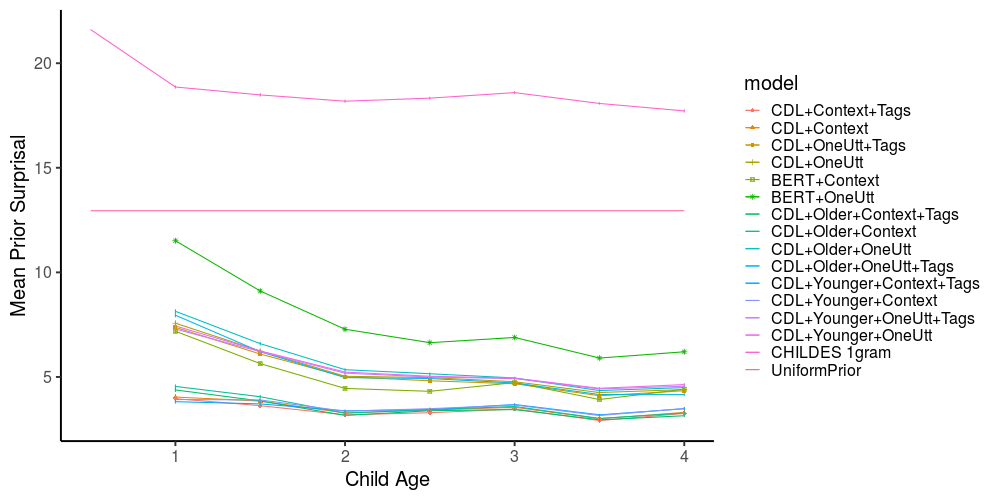

In [15]:
%%R -w 1000 -h 500
ggplot(mean_surprisal_by_age) + geom_line(aes(x=age, y=prior_surprisal_mean, color=model),
) + geom_point(aes(x=age, y=prior_surprisal_mean, color=model, shape=model)) + geom_errorbar(aes(x=age, ymin=prior_surprisal_mean - .5*prior_surprisal_sem, 
ymax=prior_surprisal_mean + .5*prior_surprisal_sem , color=model), width=0) + theme_classic(
base_size=20) + ylab('Mean Prior Surprisal') + xlab('Child Age')

In [53]:
scores_across_time_short.set.value_counts()

success    131730
failure     41538
Name: set, dtype: int64

### Posterior Entropy Stratified by Successes vs. Failures

In [54]:
%R posterior_entropy_by_age = aggregate(posterior_entropy ~ age + model + set, scores_across_time_short ,\
                function(x){mean(x)})
%R names(posterior_entropy_by_age) = c('age','model', 'set', 'posterior_entropy_mean')
%R posterior_entropy_by_age_sem = aggregate(posterior_entropy ~ age + model + set, \
        scores_across_time_short, sem)
%R names(posterior_entropy_by_age_sem) = c('age','model','set','posterior_entropy_sem')
%R posterior_entropy_by_age = merge(posterior_entropy_by_age, posterior_entropy_by_age_sem) 
%R posterior_entropy_by_age

,age,model,set,posterior_entropy_mean,posterior_entropy_sem
1,0.5,CHILDES 1gram,failure,3.562662,NaN
2,0.5,CHILDES 1gram,success,3.562662,NaN
3,0.5,UniformPrior,failure,5.731794,NaN
4,0.5,UniformPrior,success,5.731794,NaN
5,1.5,BERT+Context,failure,2.616747,0.054426
...,...,...,...,...,...
224,4.0,CDL+Younger+OneUtt+Tags,success,0.851727,0.033858
225,4.0,CHILDES 1gram,failure,3.964596,0.251652
226,4.0,CHILDES 1gram,success,3.683562,0.027170
227,4.0,UniformPrior,failure,6.185869,0.133486


In [55]:
%R -o posterior_entropy_by_age

In [60]:
posterior_entropy_by_age[posterior_entropy_by_age.posterior_entropy_sem.isna()] # Just at the top...

,age,model,set,posterior_entropy_mean,posterior_entropy_sem
1,0.5,CHILDES 1gram,failure,3.562662,NaN
2,0.5,CHILDES 1gram,success,3.562662,NaN
3,0.5,UniformPrior,failure,5.731794,NaN
4,0.5,UniformPrior,success,5.731794,NaN


In [ ]:
scores_across_time[scores_across_time.model]

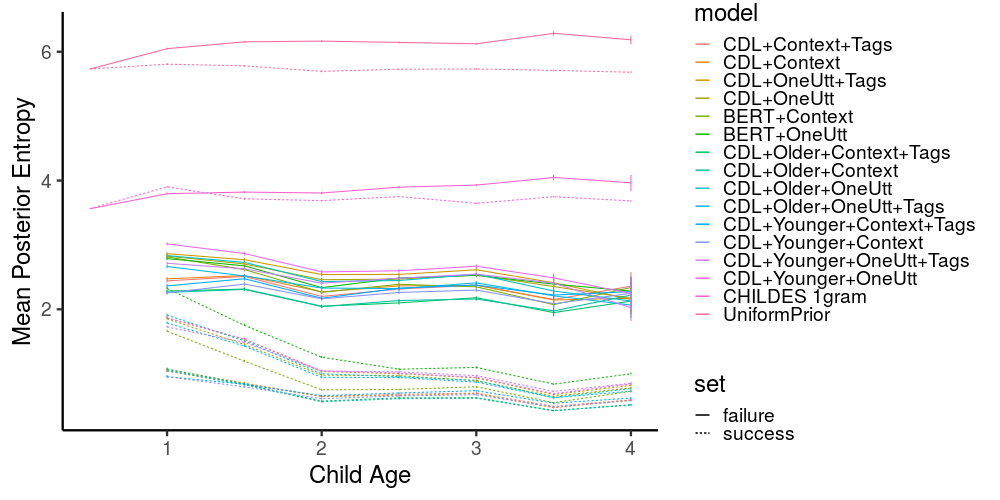

In [18]:
%%R -w 1000 -h 500
ggplot(posterior_entropy_by_age) + geom_line(aes(x=age, y=posterior_entropy_mean, color=model, linetype=set)
) + geom_errorbar(aes(x=age, ymin=posterior_entropy_mean - .5*posterior_entropy_sem, 
ymax=posterior_entropy_mean + .5*posterior_entropy_sem, color=model, linetype=set ), width=0) + theme_classic(
base_size=24) + ylab('Mean Posterior Entropy') + xlab('Child Age')

# 11 Information Gain 

In [19]:
%%R
# adjust the base from log to 2 in successes_across_time
successes_across_time$kl_flat_to_prior = -1 * log (exp(-1 * 
    successes_across_time$kl_flat_to_prior), base=2)
successes_across_time$kl_flat_to_posterior = -1 * log (exp(-1 * 
    successes_across_time$kl_flat_to_posterior), base=2)

In [20]:
%%R
mean_kl_flat_to_prior_by_age = aggregate(kl_flat_to_prior ~ age + model, successes_across_time, mean)
names(mean_kl_flat_to_prior_by_age) = c('age','model','kl_flat_to_prior')
mean_kl_flat_to_prior_by_age_sem = aggregate(kl_flat_to_prior ~ age + model,
        successes_across_time, sem)
names(mean_kl_flat_to_prior_by_age_sem) = c('age','model','kl_flat_to_prior_sem')
mean_kl_flat_to_prior_by_age = merge(mean_kl_flat_to_prior_by_age, mean_kl_flat_to_prior_by_age_sem) 


mean_kl_flat_to_posterior_by_age = aggregate(kl_flat_to_posterior ~ age + model, successes_across_time, mean)
names(mean_kl_flat_to_posterior_by_age) = c('age','model','kl_flat_to_posterior')
mean_kl_flat_to_posterior_by_age_sem = aggregate(kl_flat_to_posterior ~ age + model, 
        successes_across_time, sem)
names(mean_kl_flat_to_posterior_by_age_sem) = c('age','model','kl_flat_to_posterior_sem')
mean_kl_flat_to_posterior_by_age = merge(mean_kl_flat_to_posterior_by_age, 
    mean_kl_flat_to_posterior_by_age_sem) 

names(mean_kl_flat_to_posterior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_posterior_by_age$comparison = 'posterior'

names(mean_kl_flat_to_prior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_prior_by_age$comparison =  'fitted prior'

kls = rbind.fill(mean_kl_flat_to_posterior_by_age, mean_kl_flat_to_prior_by_age)
kls$age_in_months = kls$age * 12
head(kls)

  age            model      gain  gain_sem comparison age_in_months
1 0.5    CHILDES 1gram 11.470515        NA  posterior             6
2 0.5     UniformPrior  6.033721        NA  posterior             6
3 1.5     BERT+Context 19.871637 0.2232269  posterior            18
4 1.5      BERT+OneUtt 17.496013 0.2018063  posterior            18
5 1.5      CDL+Context 21.730639 0.2142495  posterior            18
6 1.5 CDL+Context+Tags 21.903052 0.2097652  posterior            18


In [21]:
%%R
subset(kls, comparison =='posterior' & model == 'UniformPrior')

    age        model     gain   gain_sem comparison age_in_months
2   0.5 UniformPrior 6.033721         NA  posterior             6
18  1.5 UniformPrior 5.584792 0.03672279  posterior            18
34  1.0 UniformPrior 5.390278 0.03803818  posterior            12
50  2.5 UniformPrior 5.767324 0.02815050  posterior            30
66  2.0 UniformPrior 5.686460 0.03116785  posterior            24
82  3.5 UniformPrior 5.746066 0.02624322  posterior            42
98  3.0 UniformPrior 5.774997 0.03031776  posterior            36
114 4.0 UniformPrior 5.878937 0.03402155  posterior            48


In [22]:
%%R
# how to get the unigrams on every line
unigram_posterior = subset(kls, comparison =='posterior' & model == 'UniformPrior')
unigram_posterior['comparison'] = 'perceptual data'

excluding_unigram = subset(kls, model != 'UniformPrior')
by_model = split(excluding_unigram, as.character(excluding_unigram$model))
kls_with_uniform_prior = do.call('rbind', lapply(by_model, function(one_model){
        # merge by age in months
        unigram_posterior['model'] = one_model$model[1]
        return(rbind(one_model, unigram_posterior))    
})) 

In [23]:
%%R
kls_with_uniform_prior$comparison[kls_with_uniform_prior$
    comparison == 'fitted prior'] = "context (fitted prior)"

kls_with_uniform_prior$comparison[kls_with_uniform_prior$
    comparison == 'posterior'] = "perceptual data & context\n(posterior)"

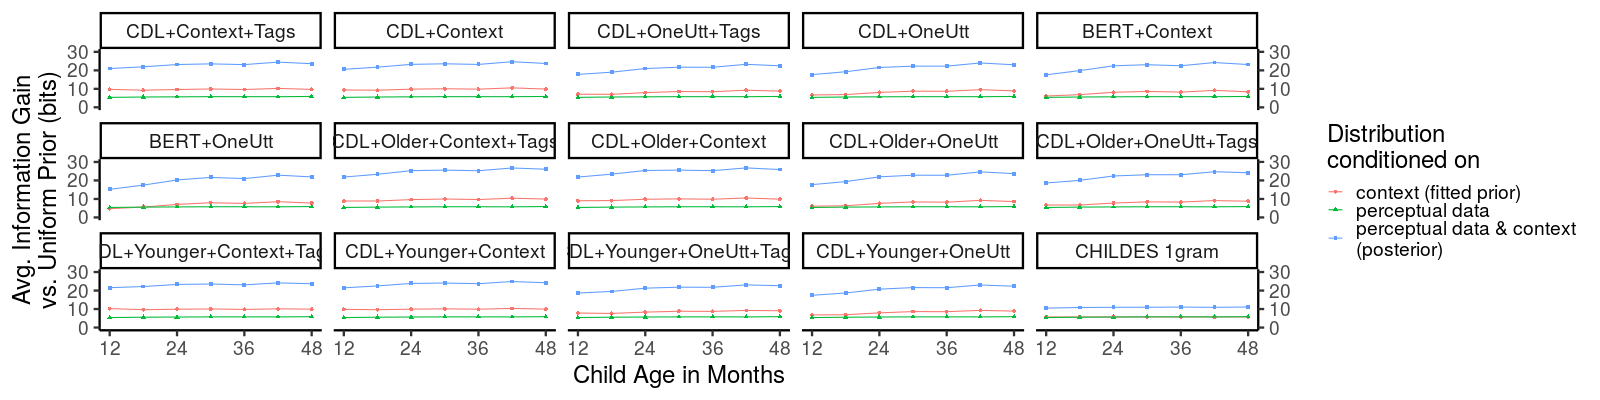

In [24]:
%%R -w 1600 -h 400
child_age_ticks = c(12,24,36,48) 
p1 = ggplot(subset(kls_with_uniform_prior, age_in_months > 6)) + geom_point(aes(x=age_in_months, 
y= gain, color=comparison,  shape=comparison)
) + facet_wrap(~model, ncol=5) + geom_line(aes(x=age_in_months, y= gain, color=comparison, 
shape=comparison)) + theme_classic(base_size=24) + coord_cartesian(ylim = c(0,30)
) + xlab('Child Age in Months') + ylab('Avg. Information Gain\nvs. Uniform Prior (bits)'
) + scale_y_continuous(sec.axis = sec_axis( trans=~.)
) + scale_color_discrete(name = "Distribution\nconditioned on") + scale_shape_discrete(
name = "Distribution\nconditioned on") + scale_x_continuous( breaks = child_age_ticks, 
labels = child_age_ticks)
ggsave('figures/information_gain_2.pdf', width=16, height=4)
print(p1)

# 12 Posterior Probability as a function of edit distance

In [25]:
%%R 
get_ref_df = function(model, single_df){
    rdf = single_df
    single_df$line_model = single_df$model
    single_df$model = model
    return(single_df) 
}

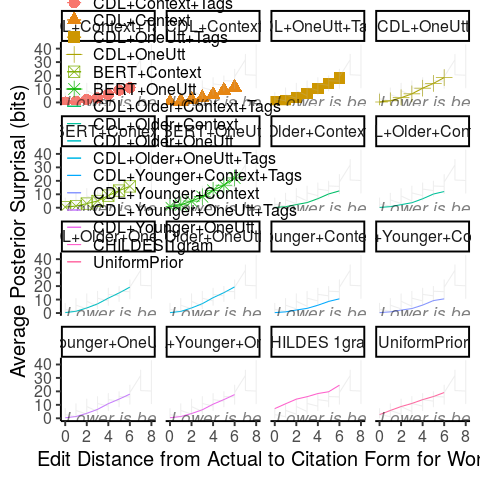

In [26]:
%%R
surprisal_by_edit_distance = aggregate(posterior_surprisal ~ edit_distance + model, successes_across_time, 
    function(x){mean(-1 * log(x, base = 2))})
names(surprisal_by_edit_distance) = c('edit_distance', 'model', 'mean_posterior_surprisal')
sem <- function(x) sd(x)/sqrt(length(x))
surprisal_by_edit_distance_sem = aggregate(posterior_surprisal ~ edit_distance + model, successes_across_time, 
    function(x){sem(-1 * log(x, base = 2))})
names(surprisal_by_edit_distance_sem) = c('edit_distance','model','mean_posterior_surprisal_sem')
surprisal_by_edit_distance = merge(surprisal_by_edit_distance, surprisal_by_edit_distance_sem)
surprisal_by_edit_distance$high = surprisal_by_edit_distance$mean_posterior_surprisal 
    + 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
surprisal_by_edit_distance$low = surprisal_by_edit_distance$mean_posterior_surprisal 
    - 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
test = subset(surprisal_by_edit_distance, edit_distance ==1 )
test$prob = exp(-1*test$mean_posterior_surprisal)


ref_dfs = do.call('rbind', lapply(unique(surprisal_by_edit_distance$model), function(model){ get_ref_df(model, surprisal_by_edit_distance)}))     


p1= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model), width = 0) + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model, 
shape=model)) + theme(legend.position=c(.3, .8), legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic") +
facet_wrap(~model) + geom_line(data=ref_dfs, aes(x=edit_distance,y=mean_posterior_surprisal),colour='gray', alpha=.25)

ggsave('figures/multiplier_by_edit_distance.pdf', height=6, width=8)    
print(p1)

In [27]:
%%R
# Multiplier for each 
unigram_prior = subset(surprisal_by_edit_distance, model == "UniformPrior")[,c('edit_distance',
    'mean_posterior_surprisal')]
names(unigram_prior)[2] = "unigram_prior_prob"

surprisal_by_edit_distance = merge(surprisal_by_edit_distance, unigram_prior)
surprisal_by_edit_distance$multiplier = 2^( surprisal_by_edit_distance$unigram_prior_prob -
    surprisal_by_edit_distance$mean_posterior_surprisal)

head(surprisal_by_edit_distance, n=10)


   edit_distance                  model mean_posterior_surprisal
1              0           BERT+Context                0.4673632
2              0            BERT+OneUtt                0.9511208
3              0            CDL+Context                0.2732820
4              0       CDL+Context+Tags                0.2509112
5              0      CDL+Older+Context                0.2192075
6              0 CDL+Older+Context+Tags                0.1997113
7              0       CDL+Older+OneUtt                0.3349723
8              0  CDL+Older+OneUtt+Tags                0.2936198
9              0             CDL+OneUtt                0.3456709
10             0        CDL+OneUtt+Tags                0.3404321
   mean_posterior_surprisal_sem      high       low unigram_prior_prob
1                    0.02334139 0.4673632 0.4673632           2.728555
2                    0.03197008 0.9511208 0.9511208           2.728555
3                    0.01544666 0.2732820 0.2732820           2.728555
4

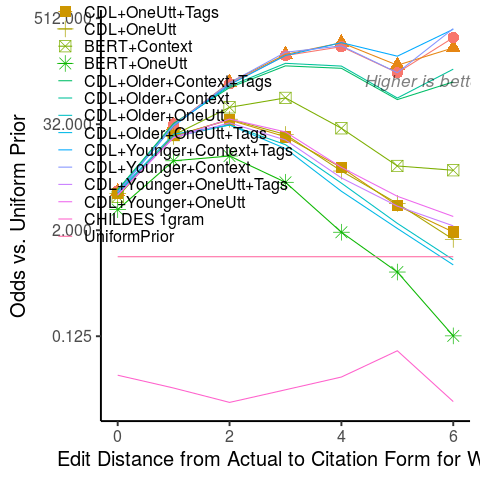

In [28]:
%%R
p2= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.2, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic") + scale_y_continuous(trans='log2')
ggsave('figures/multiplier_by_edit_dstance_log_scale.pdf', height=6, width=8)    
print(p2)

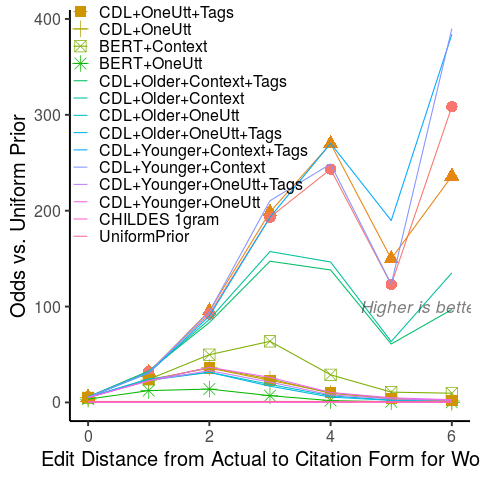

In [29]:
%%R
p2= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.3, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic")
ggsave('figures/multiplier_by_edit_dstance_linear_scale.pdf', height=6, width=8)    
print(p2)

# 13 ROC for Completions 

In [30]:
%%R
library(plotROC)

In [31]:
%%R 
scores_across_time_short$set_binarized = 0
scores_across_time_short$set_binarized[scores_across_time_short$set == 'failure'] = 1
table(scores_across_time_short$set_binarized)

[1] 131730  41538


In [32]:
%%R
# Get AUC scores into these
unique(as.character(scores_across_time_short$model))

 [1] "BERT+OneUtt"              "BERT+Context"            
 [3] "CDL+OneUtt+Tags"          "CDL+Context+Tags"        
 [5] "CDL+OneUtt"               "CDL+Context"             
 [7] "CDL+Younger+OneUtt+Tags"  "CDL+Younger+Context+Tags"
 [9] "CDL+Younger+OneUtt"       "CDL+Younger+Context"     
[11] "CDL+Older+OneUtt+Tags"    "CDL+Older+Context+Tags"  
[13] "CDL+Older+OneUtt"         "CDL+Older+Context"       
[15] "UniformPrior"             "CHILDES 1gram"           


In [33]:
%%R
library('pROC')
auc_by_model = do.call('rbind', lapply(unique(scores_across_time_short$model), 
      function(model_name){
    one_model = subset(scores_across_time_short, model == model_name)
    roc1 = roc(one_model$set_binarized, one_model$posterior_entropy)
    return(data.frame(model=model_name, auc = auc(roc1)))}))

scores_across_time_short = merge(scores_across_time_short, auc_by_model)


R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following object is masked from ‘package:plotROC’:

    ggroc


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls 

In [34]:
%%R
scores_across_time_short$model_with_auc = paste0(scores_across_time_short$model,' (AUC = ',
round(scores_across_time_short$auc, 2),')')

In [35]:
%%R
scores_across_time_short$model_with_auc[1:10]

 [1] "BERT+Context (AUC = 0.84)" "BERT+Context (AUC = 0.84)"
 [3] "BERT+Context (AUC = 0.84)" "BERT+Context (AUC = 0.84)"
 [5] "BERT+Context (AUC = 0.84)" "BERT+Context (AUC = 0.84)"
 [7] "BERT+Context (AUC = 0.84)" "BERT+Context (AUC = 0.84)"
 [9] "BERT+Context (AUC = 0.84)" "BERT+Context (AUC = 0.84)"


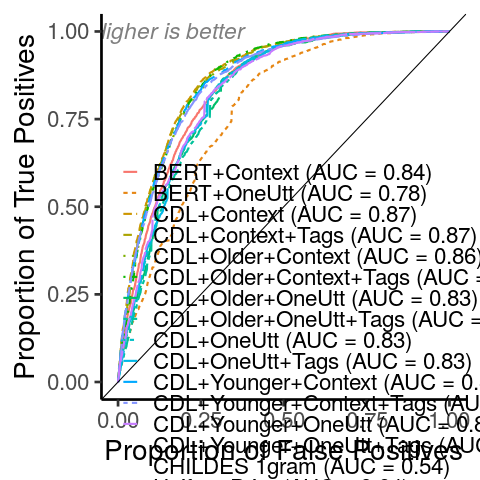

In [36]:
%%R 
p1 = ggplot(scores_across_time_short[,c('set_binarized', 'model_with_auc', 'posterior_entropy')], 
       aes(d=set_binarized, m=posterior_entropy, color=model_with_auc, linetype = model_with_auc)
) + theme_classic(base_size=28)+ geom_roc(n.cuts=0) + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + theme(legend.position=c(.67, .20),
legend.background = element_blank(), legend.title = element_blank()) + annotate("text",
label= "Higher is better", size=8, fontface="italic", x=.15, y=1, alpha =.5) + geom_abline(intercept=0, slope=1)
print(p1)
ggsave('figures/roc_2.pdf', height=12, width=12)    